Benötigte Librarys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import matplotlib.dates as mdates


In [2]:
#.\venv\Scripts\activate

Historische Daten aus Yahoo Finance einlesen

In [7]:
data = pd.read_csv("C:\WWI2021\Semester 6\Machine Learning Project\LSTM_BTC\data\BTC-USD.csv")
data

FileNotFoundError: [Errno 2] No such file or directory: '..data\\BTC-USD.csv'

Kursverlauf visuaisieren

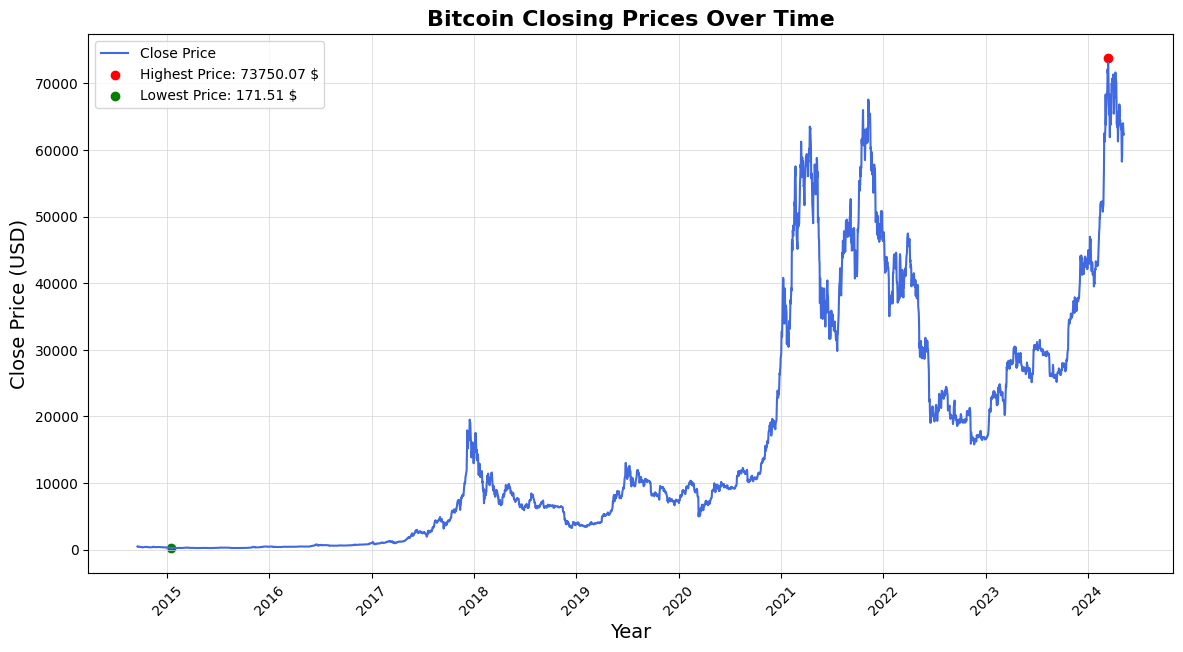

In [4]:
# Daten laden (Beispiel, wie man den DataFrame annimmt)
# data = pd.read_csv('path_to_your_file.csv')

# 'Date' zu datetime umwandeln
data['Date'] = pd.to_datetime(data['Date'])

# Runden der 'Low' und 'High' Werte auf zwei Nachkommastellen
data['Low'] = data['Low'].round(2)
data['High'] = data['High'].round(2)

# Erstellung des Plots
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Close Price', color='royalblue')

# Höchst- und Tiefstpreisen hervorheben
max_price = data['High'].max()
min_price = data['Low'].min()
max_date = data['Date'][data['High'].idxmax()]
min_date = data['Date'][data['Low'].idxmin()]
plt.scatter(max_date, max_price, color='red', label=f'Highest Price: {max_price:.2f} $')
plt.scatter(min_date, min_price, color='green', label=f'Lowest Price: {min_price:.2f} $')

# Beschriftungen und Titel
plt.title('Bitcoin Closing Prices Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.ylabel('Close Price (USD)', fontsize=14)
plt.legend()

# Hinzufügen eines Gitters
ax.grid(True, linestyle='-', linewidth='0.5', color='lightgray')  # Lichtgraues Gitter hinzufügen
ax.set_yticks(range(0, int(data['Close'].max()), 10000))  # Y-Achsen-Ticks in 10.000 $ Schritten

# Anzeigen des Plots
plt.show()

Feature Engineering:

Korrelationsmatrix der Features

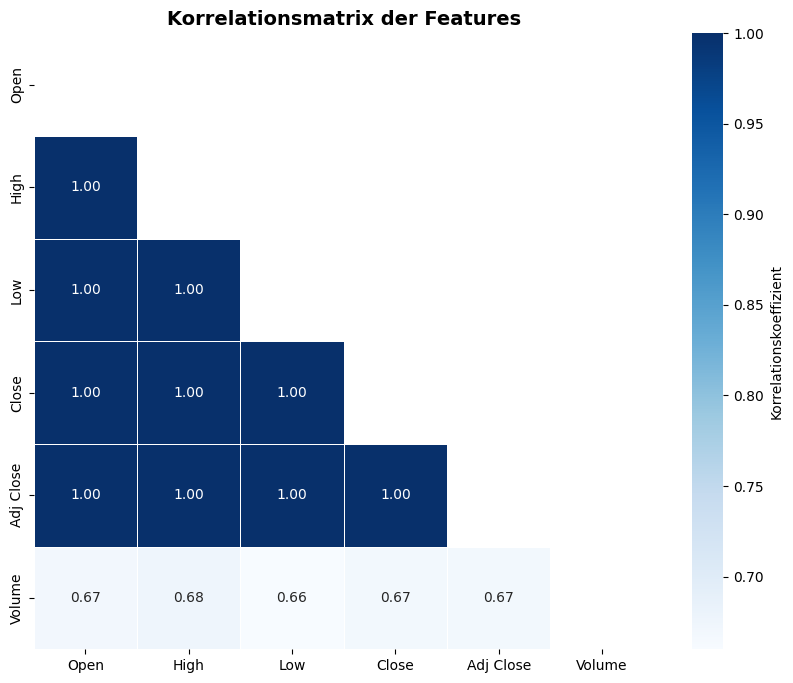

In [5]:
# Berechnen der Korrelationsmatrix
corr = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

# Erstellen einer Maske für die obere Dreiecksmatrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Erstellen einer Heatmap für die Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', mask=mask, cbar_kws={'label': 'Korrelationskoeffizient'},
            linewidths=0.5, linecolor='white')  # Blaues Farbschema mit weißen Linien
plt.title('Korrelationsmatrix der Features', fontsize=14, fontweight='bold')
plt.show()

Basierend auf der hohen Korrelation der Features habe ich mich dazu entscheiden den closepreis als feature zu verwenden und alle anderen features zu entfernen

In [6]:
data_prep = data.drop(['Open', 'High', 'Low','Adj Close', 'Volume'], axis=1)

# Überprüfung des aktualisierten DataFrames
print(data_prep.head())


        Date       Close
0 2014-09-17  457.334015
1 2014-09-18  424.440002
2 2014-09-19  394.795990
3 2014-09-20  408.903992
4 2014-09-21  398.821014


Feature-Betrachtung

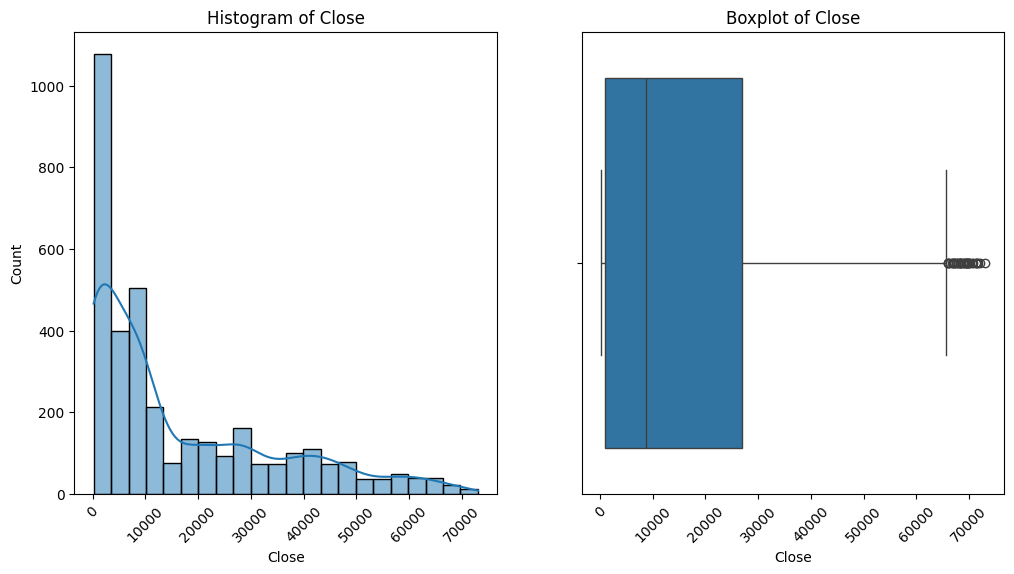

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Einstellungen für die Visualisierung
plt.figure(figsize=(12, 6))

# Histogramm des 'Close'-Features
plt.subplot(1, 2, 1)
sns.histplot(data_prep['Close'], kde=True)
plt.title('Histogram of Close')
plt.xticks(range(0, int(data_prep['Close'].max()), 10000), rotation=45)  # X-Achsen-Beschriftungen um 45 Grad drehen

# Boxplot des 'Close'-Features
plt.subplot(1, 2, 2)
sns.boxplot(x=data_prep['Close'])
plt.title('Boxplot of Close')
plt.xticks(range(0, int(data_prep['Close'].max()), 10000), rotation=45)  # Wiederholung für den Boxplot

# Anzeigen des Plots
plt.show()


Trading-Indikatoren hinzufügen

In [8]:
# ersten 150 Tage nicht nutzbar da der ema150 nicht berechnet werden kann
data_prep['RSI']=ta.rsi(data_prep.Close, length=15)
data_prep['EMA20']=ta.ema(data_prep.Close, length=20)
data_prep['EMA100']=ta.ema(data_prep.Close, length=100)
data_prep['EMA150']=ta.ema(data_prep.Close, length=150)
data_prep

,Date,Close,RSI,EMA20,EMA100,EMA150
0,2014-09-17,457.334015,NaN,NaN,NaN,NaN
1,2014-09-18,424.440002,NaN,NaN,NaN,NaN
2,2014-09-19,394.795990,NaN,NaN,NaN,NaN
3,2014-09-20,408.903992,NaN,NaN,NaN,NaN
4,2014-09-21,398.821014,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3517,2024-05-04,63891.472656,49.568973,63492.451518,60023.934751,55814.205645
3518,2024-05-05,64031.132813,49.895138,63543.754499,60103.285208,55923.039118
3519,2024-05-06,63161.949219,47.832307,63507.392091,60163.852812,56018.918722
3520,2024-05-07,62334.816406,45.897570,63395.718216,60206.842190,56102.572996


TargetNextClose-Column hinzufügen. Holt den Close des nächsten Tages in die aktuelle Zeile

In [9]:
data_prep['TargetNextClose'] = data_prep['Close'].shift(-1)
data_prep

,Date,Close,RSI,EMA20,EMA100,EMA150,TargetNextClose
0,2014-09-17,457.334015,NaN,NaN,NaN,NaN,424.440002
1,2014-09-18,424.440002,NaN,NaN,NaN,NaN,394.795990
2,2014-09-19,394.795990,NaN,NaN,NaN,NaN,408.903992
3,2014-09-20,408.903992,NaN,NaN,NaN,NaN,398.821014
4,2014-09-21,398.821014,NaN,NaN,NaN,NaN,402.152008
...,...,...,...,...,...,...,...
3517,2024-05-04,63891.472656,49.568973,63492.451518,60023.934751,55814.205645,64031.132813
3518,2024-05-05,64031.132813,49.895138,63543.754499,60103.285208,55923.039118,63161.949219
3519,2024-05-06,63161.949219,47.832307,63507.392091,60163.852812,56018.918722,62334.816406
3520,2024-05-07,62334.816406,45.897570,63395.718216,60206.842190,56102.572996,62322.437500


Daten bereinigen

In [10]:
data_clean = data_prep
data_clean.dropna(inplace=True)
data_clean.reset_index(drop=True, inplace=True)

#ggf nur date raus
data_clean.drop([ 'Close', 'Date'], axis=1, inplace=True)
data_clean


,RSI,EMA20,EMA100,EMA150,TargetNextClose
0,50.019072,229.312807,288.640505,327.932773,257.321014
1,58.174526,231.980256,288.020317,326.997518,234.824997
2,49.315763,232.251183,286.966944,325.776690,233.843002
3,48.967016,232.402785,285.914985,324.559025,243.610001
4,52.543343,233.470139,285.077263,323.486853,236.326004
...,...,...,...,...,...
3367,47.271348,63450.449293,59945.802672,55705.785954,63891.472656
3368,49.568973,63492.451518,60023.934751,55814.205645,64031.132813
3369,49.895138,63543.754499,60103.285208,55923.039118,63161.949219
3370,47.832307,63507.392091,60163.852812,56018.918722,62334.816406


In [11]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
df_scaled = sc.fit_transform(data_clean)
print(df_scaled)

[[4.73730553e-01 0.00000000e+00 7.79925300e-04 1.41124086e-03
  6.42570167e-04]
 [5.71810073e-01 3.89258577e-05 7.69582797e-04 1.39449606e-03
  3.33868515e-04]
 [4.65272382e-01 4.28794845e-05 7.52016329e-04 1.37263836e-03
  3.20393087e-04]
 ...
 [4.72240089e-01 9.23942559e-01 9.98273042e-01 9.96785627e-01
  8.63851494e-01]
 [4.47431974e-01 9.23411925e-01 9.99283092e-01 9.98502254e-01
  8.52501162e-01]
 [4.24164341e-01 9.21782277e-01 1.00000000e+00 1.00000000e+00
  8.52331292e-01]]


In [12]:
# backcandles = windowing
backcandles = 10
num_features = 4  # Vier Features: RSI, EMA20, EMA100, EMA150
X = [[] for _ in range(num_features)]

# Generieren der Feature-Sets
for j in range(num_features):
    for i in range(backcandles, df_scaled.shape[0]):
        X[j].append(df_scaled[i-backcandles:i, j])

# Achse verschieben
X = np.moveaxis(X, 0, 2)

# Anpassen von y, um die Länge von X zu entsprechen
yi = df_scaled[backcandles:, -1]  # Letzte Spalte ist TargetNextClose
y = np.reshape(yi, (len(yi), 1))

# Umwandeln von X in ein Numpy-Array
X = np.array(X)

print(X)
print("Shape of X:", X.shape)
print(y)
print("Shape of y:", y.shape)


[[[4.73730553e-01 0.00000000e+00 7.79925300e-04 1.41124086e-03]
  [5.71810073e-01 3.89258577e-05 7.69582797e-04 1.39449606e-03]
  [4.65272382e-01 4.28794845e-05 7.52016329e-04 1.37263836e-03]
  ...
  [5.04825575e-01 8.68107294e-05 6.76898527e-04 1.27314442e-03]
  [5.08437370e-01 9.96974785e-05 6.64373554e-04 1.25519641e-03]
  [4.62977060e-01 9.94643947e-05 6.49270861e-04 1.23545693e-03]]

 [[5.71810073e-01 3.89258577e-05 7.69582797e-04 1.39449606e-03]
  [4.65272382e-01 4.28794845e-05 7.52016329e-04 1.37263836e-03]
  [4.61078262e-01 4.50917968e-05 7.34473433e-04 1.35083730e-03]
  ...
  [5.08437370e-01 9.96974785e-05 6.64373554e-04 1.25519641e-03]
  [4.62977060e-01 9.94643947e-05 6.49270861e-04 1.23545693e-03]
  [4.78527402e-01 1.03304772e-04 6.35429837e-04 1.21667016e-03]]

 [[4.65272382e-01 4.28794845e-05 7.52016329e-04 1.37263836e-03]
  [4.61078262e-01 4.50917968e-05 7.34473433e-04 1.35083730e-03]
  [5.04088060e-01 6.06676063e-05 7.20503236e-04 1.33164113e-03]
  ...
  [4.62977060e-01 

Datensatz in Training und Test aufteilen. 80/20

In [13]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2689
(2689, 10, 4)
(673, 10, 4)
(2689, 1)
(673, 1)
[[0.00038752]
 [0.00037016]
 [0.00035584]
 ...
 [0.26191566]
 [0.27473502]
 [0.27417039]]


LSTM Modell erstellen

In [14]:
import mlflow
import mlflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation
from tensorflow.keras import optimizers

# Starte mlflow Experiment
mlflow.start_run()

#  4 Features
lstm_input = Input(shape=(backcandles, 4), name='lstm_input')

# LSTM Layer
inputs = LSTM(150, name='first_layer')(lstm_input)

# Dense Layer für die Ausgabe
inputs = Dense(1, name='dense_layer')(inputs)

# Ausgabe-Layer
output = Activation('linear', name='output')(inputs)

# Erstellen des Modells
model = Model(inputs=lstm_input, outputs=output)

# Optimizer
adam = optimizers.Adam()

# Kompilieren des Modells
model.compile(optimizer=adam, loss='mse')

# Training des Modells
history = model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)

# Hyperparameter aufzeichnen
mlflow.log_param("batch_size", 15)
mlflow.log_param("epochs", 30)
mlflow.log_param("optimizer", "Adam")

# Metriken aufzeichnen
for metric_name, metric_value in history.history.items():
    mlflow.log_metric(metric_name, metric_value[-1])  # Nur das letzte Epoch wird aufgezeichnet

# mlflow Laufzeit beenden
mlflow.end_run()


Epoch 1/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0073
Epoch 2/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4883e-04 - val_loss: 0.0076
Epoch 3/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0025e-04 - val_loss: 0.0024
Epoch 4/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6649e-04 - val_loss: 0.0017
Epoch 5/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1598e-04 - val_loss: 0.0025
Epoch 6/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1994e-04 - val_loss: 0.0014
Epoch 7/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7159e-04 - val_loss: 0.0018
Epoch 8/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6761e-04 - val_loss: 0.0013
Epoch 9/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0445e-04 - val_loss: 0.0016
Epoch 10/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9834e-04 - val_loss: 0.0013
Epoch 11/30
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3209e-04 - val_loss: 0.0012
Epoch 12/30


In [16]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0.2530262] [0.27908484]
[0.25649524] [0.29403334]
[0.26205358] [0.29531679]
[0.27932072] [0.2934106]
[0.28516325] [0.28336905]
[0.2836641] [0.2711575]
[0.27265826] [0.26228394]
[0.2584951] [0.27447172]
[0.24735618] [0.27938226]
[0.25818935] [0.28303805]


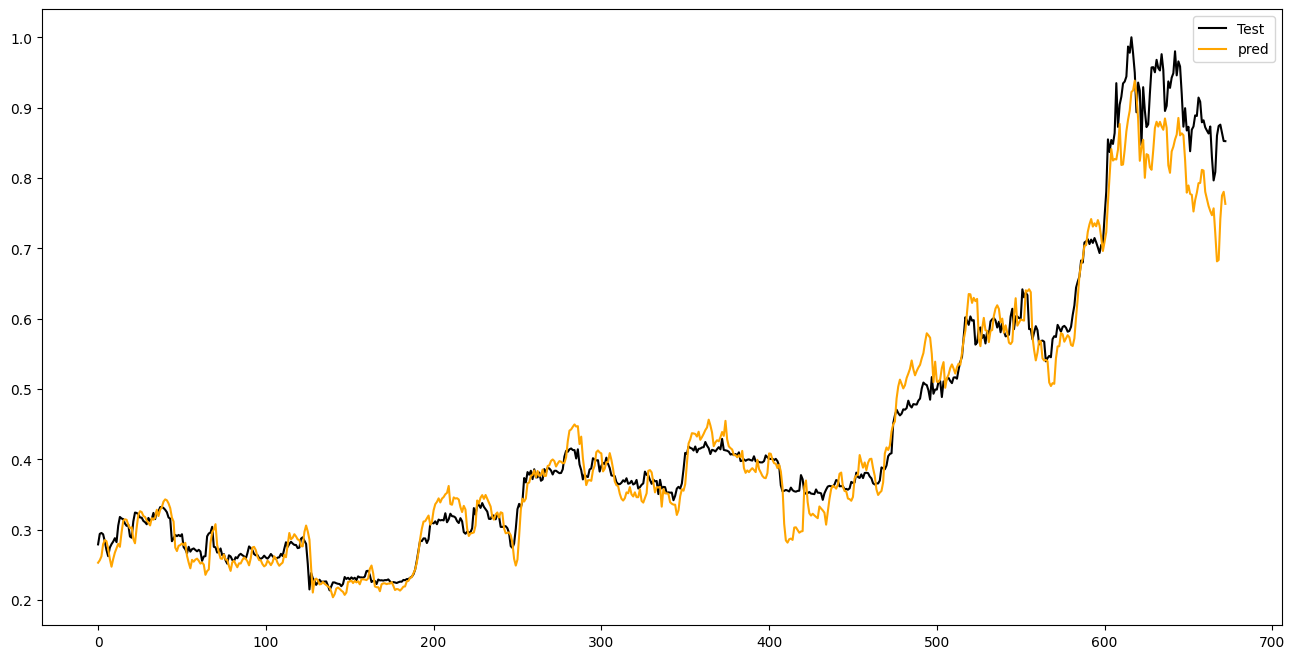

In [17]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'orange', label = 'pred')
plt.legend()
plt.show()

Eigentliche gute Vorhersage.
Jetzt mehr backcandles ausprobieren, hyperparamter anapassen. inputs wo 150 ist. möglichkeit weitere indikatoren oder wie auch immer.

PROBLEM: Warum das Modell einen Denkfehler hat: Das Modell lernt, dass der aktuelle closingprice nicht all zu weit vom nächsten closingpreis entfernt seien wird. Jeder vorhergesagte Wert der nah am Closingpreis des vorherigen Tages ist, sieht aus als sei er genau.
Es sieht gut aus aber man kann erkennen, dass vorhersage nur 1 Tag verzögerter tatsächlicher Wert ist.
Modell versucht Closing Preis des nächsten Tages vorherzusagen anhand vergangener Daten. Das wird für jeden Tag getestet und soll zukpünftige Werte vorherzusagen

Neuer Ansatz. Target ist der Unterschied zwischen Close der aktuellen Kerze zur nächsten Close Kerze. Es wird nun statt dem Closepreis des nächsten Tages vorherzusagen, versucht um wie viel der preis hoch oder runter geht. Wo ist der Unterschied? Nächster candle Price vs Preisbewegung.



Zeigt, LSTM kann nicht vorhersagen um wie viel der Preis steigen oder fallen wird

Möglich Modifikation: andere Indikatoren die mehr verraten. Wie viele Backcandles braucht das Modell um gut zu sein. Hyperparamter tunen, Layer, Nodes per Layer

variablen so ändern dass hier ein andere Plot rauskommt der zeigt, was tatsächlich passiert